# Google Analytics Customer Revenue Prediction
## BMGT 438A Google Team
### Lauren Kim, Dennis Morzob, Ekansh Vinaik, Jake Wurman, Anna Xi

This project aims to predict sales and revenue from customers (and eventually, the natural log of sales) based on a Google Analytics dataset.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import sys
import math
import random

from pandas.io.json import json_normalize
from datetime import datetime

In [31]:
plt.style.use('ggplot')

This below portion was drafted using known good features. 

In [14]:
gc.enable()

features = ['channelGrouping', 'date', 'fullVisitorId', 'visitId',\
       'visitNumber', 'visitStartTime', 'device.browser',\
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',\
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',\
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',\
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',\
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',\
       'trafficSource.adContent', 'trafficSource.campaign',\
       'trafficSource.isTrueDirect', 'trafficSource.keyword',\
       'trafficSource.medium', 'trafficSource.referralPath',\
       'trafficSource.source', 'customDimensions']

def load_df(csv_path):
    # JSON represents the columns that are made of JSON strings
    JSON = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    # p represents the percent of rows to keep
    p = .01
    
    out = pd.DataFrame()
    all_dfs = pd.read_csv(csv_path, sep=',', skiprows=lambda i: i>0 and random.random() > p,
            converters={column: json.loads for column in JSON}, 
            dtype={'fullVisitorId': 'str'},
            chunksize=100000)
    for df in all_dfs:
        df.reset_index(drop=True, inplace=True)
        for column in JSON:
            column_as_df = json_normalize(df[column])
            column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
            df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

        keep = df[features]
        del df
        gc.collect()
        out = pd.concat([out, keep], axis=0).reset_index(drop=True)
    return out

In [17]:
%%time
df = load_df('./train.csv')

print('train date:', min(df['date']), 'to', max(df['date']))

train date: 20160801 to 20180430
CPU times: user 37.7 s, sys: 11.4 s, total: 49.1 s
Wall time: 50.5 s


In [18]:
df['totals.transactionRevenue'].fillna(0, inplace=True)
df['totals.transactionRevenue'] = np.log1p(df['totals.transactionRevenue'].astype(float))
print(df['totals.transactionRevenue'].describe())

count    17168.000000
mean         0.207752
std          1.917750
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         23.605577
Name: totals.transactionRevenue, dtype: float64


# 

In [19]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17168 entries, 0 to 17167
Data columns (total 30 columns):
channelGrouping               17168 non-null object
date                          17168 non-null int64
fullVisitorId                 17168 non-null object
visitId                       17168 non-null int64
visitNumber                   17168 non-null int64
visitStartTime                17168 non-null int64
device.browser                17168 non-null object
device.deviceCategory         17168 non-null object
device.isMobile               17168 non-null bool
device.operatingSystem        17168 non-null object
geoNetwork.city               17168 non-null object
geoNetwork.continent          17168 non-null object
geoNetwork.country            17168 non-null object
geoNetwork.metro              17168 non-null object
geoNetwork.networkDomain      17168 non-null object
geoNetwork.region             17168 non-null object
geoNetwork.subContinent       17168 non-null object
totals.bounce

In [20]:
null_cnt = df.isnull().sum().sort_values()
print(null_cnt[null_cnt > 0])

totals.pageviews                  4
totals.newVisits               4086
totals.bounces                 8326
trafficSource.keyword         10691
trafficSource.referralPath    11332
trafficSource.isTrueDirect    11775
trafficSource.adContent       16513
dtype: int64


In [21]:
# fillna object feature
for col in ['trafficSource.keyword',
            'trafficSource.referralPath',
            'trafficSource.adContent']:
    df[col].fillna('unknown', inplace=True)

# fillna numeric feature
df['totals.pageviews'].fillna(1, inplace=True)
df['totals.newVisits'].fillna(0, inplace=True)
df['totals.bounces'].fillna(0, inplace=True)
df['totals.pageviews'] = df['totals.pageviews'].astype(int)
df['totals.newVisits'] = df['totals.newVisits'].astype(int)
df['totals.bounces'] = df['totals.bounces'].astype(int)

# fillna boolean feature
df['trafficSource.isTrueDirect'].fillna(False, inplace=True)

In [22]:
# drop constant
constants = [col for col in df.columns if df[col].nunique() == 1]

print('drop columns:', constants)
df.drop(constants, axis=1, inplace=True)

drop columns: []


In [23]:
# pickup any visitor
df[df['fullVisitorId'] == '7813149961404844386'].sort_values(by='visitNumber')[
    ['date','visitId','visitNumber','totals.hits','totals.pageviews']].head(20)

,date,visitId,visitNumber,totals.hits,totals.pageviews
1208,20161209,1481305812,22,2,2
7560,20170109,1483974128,28,1,1
2036,20170412,1492022498,116,18,17


In [24]:
revenue = df[df['totals.transactionRevenue'] > 0].copy()
print(len(revenue))
revenue.head()

200


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,...,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,customDimensions
50,Referral,20160902,8516473451212465925,1472845932,1,1472845932,Chrome,desktop,False,Macintosh,...,29,19.641599,unknown,(not set),False,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
159,Organic Search,20170312,8769206328217001636,1489338979,2,1489338979,Chrome,desktop,False,Windows,...,13,16.648136,unknown,(not set),True,(not provided),organic,unknown,google,"[{'index': '4', 'value': 'North America'}]"
301,Referral,20170113,2513134404212328094,1484341012,4,1484341012,Chrome,desktop,False,Macintosh,...,26,18.805535,unknown,(not set),True,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"
384,Organic Search,20161110,3122295275432356222,1478813336,1,1478813336,Chrome,desktop,False,Macintosh,...,49,19.676325,unknown,(not set),False,unknown,(none),unknown,(direct),"[{'index': '4', 'value': 'North America'}]"
459,Referral,20180117,147321363109389105,1516227960,2,1516227960,Chrome,desktop,False,Macintosh,...,22,19.030120,unknown,(not set),True,unknown,(none),/,(direct),"[{'index': '4', 'value': 'North America'}]"


In [32]:
def plotCategoryRateBar(a, b, colName, topN=np.nan):
    if topN == topN: # isNotNan
        vals = b[colName].value_counts()[:topN]
        subA = a.loc[a[colName].isin(vals.index.values), colName]
        temp = pd.DataFrame({'All':subA.value_counts() / len(a), 'Revenue':vals / len(b)})
    else:
        temp = pd.DataFrame({'All':a[colName].value_counts() / len(a), 'Revenue':b[colName].value_counts() / len(b)})
    temp.sort_values('Revenue').plot.barh()
    plt.xlabel('Ratio of Total')
    plt.ylabel('Grouping')

## customDimensions

unique customDimensions count: 6


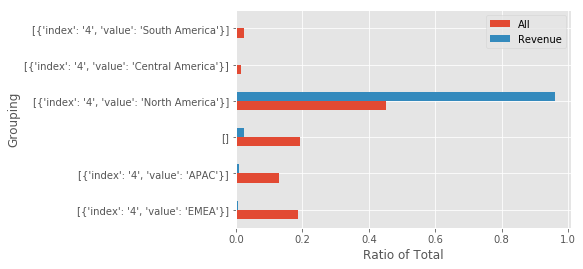

In [33]:
print('unique customDimensions count:', df['customDimensions'].nunique())
plotCategoryRateBar(df, revenue, 'customDimensions')

## date

In [27]:
format_str = '%Y%m%d'
df['formatted_date'] = df['date'].apply(lambda x: datetime.strptime(str(x), format_str))
df['_year'] = df['formatted_date'].apply(lambda x:x.year)
df['_month'] = df['formatted_date'].apply(lambda x:x.month)
df['_quarterMonth'] = df['formatted_date'].apply(lambda x:x.day//8)
df['_day'] = df['formatted_date'].apply(lambda x:x.day)
df['_weekday'] = df['formatted_date'].apply(lambda x:x.weekday())

df.drop(['date','formatted_date'], axis=1, inplace=True)

## channelGrouping
* The channel via which the user came to the Store.

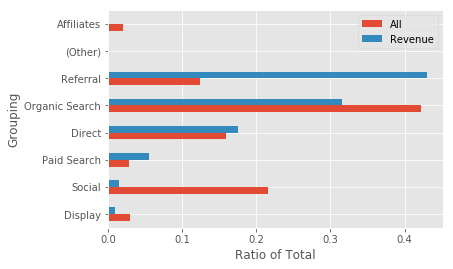

In [34]:
plotCategoryRateBar(df, revenue, 'channelGrouping')

## fullVisitorId
* A unique identifier for each user of the Google Merchandise Store.

## visitId
* An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user.   
For a completely unique ID, you should use a combination of fullVisitorId and visitId.

## newVisits


In [37]:
print('train all:', len(df))
print('train unique fullVisitorId:', df['fullVisitorId'].nunique())
print('train unique visitId:', df['visitId'].nunique())

train all: 17168
train unique fullVisitorId: 16987
train unique visitId: 17165


In [38]:
print(df['visitNumber'].value_counts()[:5])
print('-' * 30)
print(df['totals.newVisits'].value_counts())
print('-' * 30)
print(df['totals.bounces'].value_counts())

1    13082
2     1817
3      693
4      391
5      232
Name: visitNumber, dtype: int64
------------------------------
1    13082
0     4086
Name: totals.newVisits, dtype: int64
------------------------------
1    8842
0    8326
Name: totals.bounces, dtype: int64


In [39]:
df['_visitStartHour'] = df['visitStartTime'].apply(
    lambda x: str(datetime.fromtimestamp(x).hour))

## device

unique browser count: 21


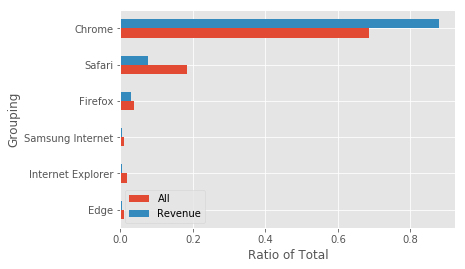

In [40]:
print('unique browser count:', df['device.browser'].nunique())
plotCategoryRateBar(df, revenue, 'device.browser', 10)

In [41]:
pd.crosstab(df['device.deviceCategory'], df['device.isMobile'], margins=False)

df['isMobile'] = True
df.loc[df['device.deviceCategory'] == 'desktop', 'isMobile'] = False

unique operatingSystem count: 15


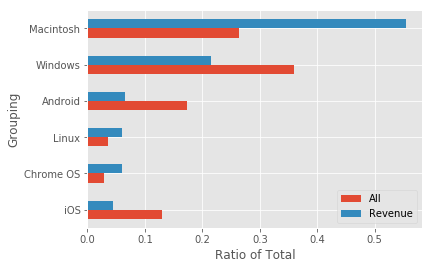

In [43]:
print('unique operatingSystem count:', df['device.operatingSystem'].nunique())
plotCategoryRateBar(df, revenue, 'device.operatingSystem', 10)

## geoNetwork

unique geoNetwork.city count: 404


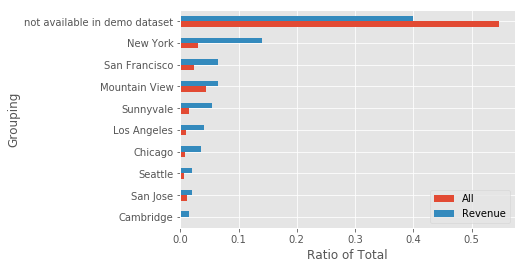

In [44]:
print('unique geoNetwork.city count:', df['geoNetwork.city'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.city', 10)

unique geoNetwork.region count: 265


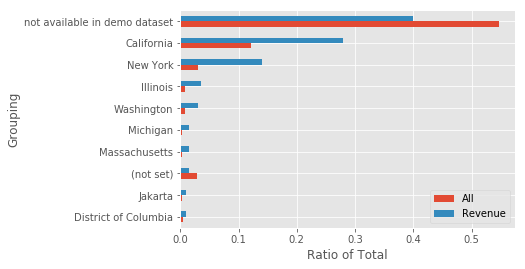

In [45]:
print('unique geoNetwork.region count:', df['geoNetwork.region'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.region', 10)

unique geoNetwork.subContinent count: 22


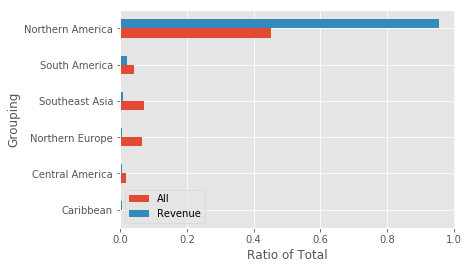

In [46]:
print('unique geoNetwork.subContinent count:', df['geoNetwork.subContinent'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.subContinent', 10)

unique geoNetwork.continent count: 6


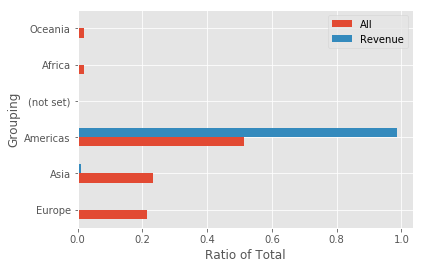

In [47]:
print('unique geoNetwork.continent count:', df['geoNetwork.continent'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.continent')

unique geoNetwork.metro count: 71


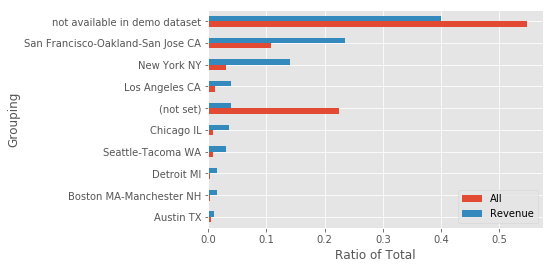

In [48]:
print('unique geoNetwork.metro count:', df['geoNetwork.metro'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.metro', 10)

unique geoNetwork.networkDomain count: 2429


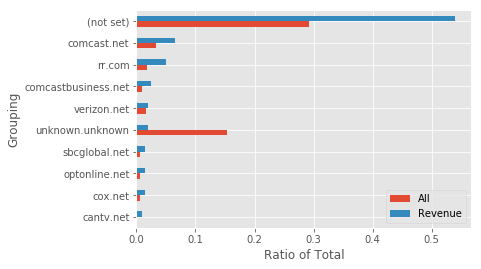

In [49]:
print('unique geoNetwork.networkDomain count:', df['geoNetwork.networkDomain'].nunique())
plotCategoryRateBar(df, revenue, 'geoNetwork.networkDomain', 10)

## totals

In [50]:
print(df['totals.hits'].value_counts()[:10])

df['totals.hits'] = df['totals.hits'].astype(int)

1     8765
2     2349
3     1362
4      818
5      612
6      486
7      382
8      270
9      236
10     214
Name: totals.hits, dtype: int64


In [51]:
print(df['totals.pageviews'].value_counts()[:10])

df['totals.pageviews'] = df['totals.pageviews'].astype(int)

1     8896
2     2471
3     1426
4      862
5      647
6      483
7      374
8      253
9      246
10     199
Name: totals.pageviews, dtype: int64


## trafficSource

False    11775
True      5393
Name: trafficSource.isTrueDirect, dtype: int64


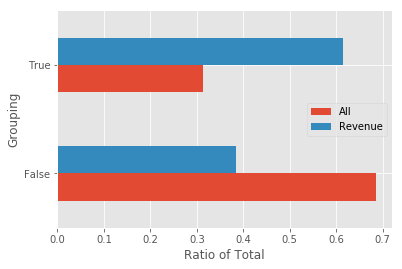

In [54]:
print(df['trafficSource.isTrueDirect'].value_counts())
plotCategoryRateBar(df, revenue, 'trafficSource.isTrueDirect')

unique trafficSource.source count: 83


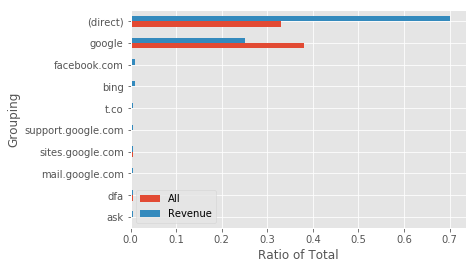

In [58]:
print('unique trafficSource.source count:', df['trafficSource.source'].nunique())
plotCategoryRateBar(df, revenue, 'trafficSource.source', 10)

df['_sourceGpmall'] = (df['trafficSource.source'] == 'mall.googleplex.com').astype(np.uint8)